# Kaggle Titanic survival - feature selection 1 (univariate statistical selection)

Reducing the number of features we use can have three benefits:

* Simplifies model explanation
* Model fit may be improved by the removal of features that add no value
* Model will be faster to fit

In this notebook we will use a simple statistical method for selecting features called univariate feature selection. We will examine the correlation between each feature and the target label value. This is called univariate statistics because we examine each feature independently. 

Two key advantages of this method are:

* It is simple
* It is fast

Two key disadvantage of this method are:

* It may miss features which have little effect alone, but which are influential when combined
* It may include features which are highly correlated which could be reduced to choosing just one of the highly correlated features.

The machine learning model we will use to test the feature selection is as previously described:

https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/02_logistic_regression.ipynb

We will go through the following steps:

* Download and save pre-processed data
* Split data into features (X) and label (y)
* Calculate the correlation of each feature with the target label value
* Sort by correlation (ignoring the +ve/-ve sign)
* Test the features in our logistic regression model

In [1]:
# Hide warnings (to keep notebook tidy; do not usually do this)
import warnings
warnings.filterwarnings("ignore")

## Load modules

A standard Anaconda install of Python (https://www.anaconda.com/distribution/) contains all the necessary modules.

In [2]:
import numpy as np
import pandas as pd
# Import machine learning methods
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

## Load data

The section below downloads pre-processed data, and saves it to a subfolder (from where this code is run).
If data has already been downloaded that cell may be skipped.

Code that was used to pre-process the data ready for machine learning may be found at:
https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/01_preprocessing.ipynb

In [3]:
download_required = True

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

In [4]:
data = pd.read_csv('data/processed_data.csv')
# Make all data 'float' type
data = data.astype(float)

The first column is a passenger index number. We will remove this, as this is not part of the original Titanic passenger data.

In [5]:
# Drop Passengerid (axis=1 indicates we are removing a column rather than a row)
# We drop passenger ID as it is not original data

data.drop('PassengerId', inplace=True, axis=1)

## Divide into X (features) and y (labels)

We will separate out our features (the data we use to make a prediction) from our label (what we are truing to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (survive or not) `y`.

In [6]:
X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'

## Calculate correlation coefficients

In [7]:
from scipy.stats.stats import pearsonr
features = list(X)
correlation = []
significance = []
for feature in features:
    correl = pearsonr(X[feature].values, y.values)
    correlation.append(correl[0])
    significance.append(correl[1])
df = pd.DataFrame()
df['feature'] = features
df['correlation'] = correlation
df['abs_correlation'] = np.abs(correlation)
df['significance'] = significance
df['significant'] = df['significance'] < 0.05 # Label those P<0.01
df.sort_values(by='abs_correlation', ascending=False, inplace=True)

Show features in order of correlation with survival.

In [8]:
df

,feature,correlation,abs_correlation,significance,significant
10,male,-0.543351,0.543351,1.406066e-69,True
0,Pclass,-0.338481,0.338481,2.537047e-25,True
9,CabinNumberImputed,-0.321842,0.321842,6.404266e-23,True
7,CabinLetterImputed,-0.316912,0.316912,3.090891e-22,True
23,CabinLetter_missing,-0.316912,0.316912,3.090891e-22,True
4,Fare,0.257307,0.257307,6.120189e-15,True
8,CabinNumber,0.235409,0.235409,1.100977e-12,True
16,CabinLetter_B,0.175095,0.175095,1.441584e-07,True
11,Embarked_C,0.168240,0.168240,4.397151e-07,True
13,Embarked_S,-0.155660,0.155660,3.036111e-06,True


Get ordered feature list.

In [9]:
ordered_features = list(df['feature'])

In [10]:
ordered_features

['male',
 'Pclass',
 'CabinNumberImputed',
 'CabinLetterImputed',
 'CabinLetter_missing',
 'Fare',
 'CabinNumber',
 'CabinLetter_B',
 'Embarked_C',
 'Embarked_S',
 'CabinLetter_D',
 'CabinLetter_E',
 'CabinLetter_C',
 'AgeImputed',
 'Parch',
 'Age',
 'Embarked_missing',
 'EmbarkedImputed',
 'CabinLetter_F',
 'SibSp',
 'CabinLetter_T',
 'CabinLetter_A',
 'CabinLetter_G',
 'Embarked_Q']

## Testing our selected features

After statistical selection we may simply choose the top *k* features, or we may choose those labelled as significant (P<0.05). 

Here we will inclemently add features to the list of features to use (chosen in order of their correlation coefficients), and see the effect on model accuracy and ROC AUC as measured by k-fold stratification.

If you are not familiar with k-fold stratification, have a look at:

https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/03_k_fold.ipynb

If you are not familiar with ROC AUC, have a look at:

https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/06_roc_sensitivity_specificity.ipynb

In [11]:
def standardise_data(X_train, X_test):
    
    # Initialise a new scaling object for normalising input data
    sc = StandardScaler() 

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_std=sc.transform(X_train)
    test_std=sc.transform(X_test)
    
    return train_std, test_std

In [12]:
# Create list to store accuracies
accuracy_by_feature_number = []
roc_auc_by_feature_number = []

# Loop through feature list
number_of_features = len(ordered_features)
for i in range(number_of_features):
    # print ("{0} features of {1}".format(i, number_of_features))
    features_to_use = ordered_features[0:i+1]
    X_selected = X[features_to_use]
    
    # Convert to NumPy (needed for k-fold method)
    # Convert DataFrames to NumPy arrays
    X_np = X_selected.values
    y_np = y.values
    
    #%% Run k fold model

    # Set up lists to hold results for each k-fold run
    test_acc_results = []
    test_auc_results = []

    # Set up splits
    number_of_splits = 10
    skf = StratifiedKFold(n_splits = number_of_splits)
    skf.get_n_splits(X_np, y)

    # Loop through the k-fold splits
    for train_index, test_index in skf.split(X_np, y_np):
        # Get X and Y train/test
        X_train, X_test = X_np[train_index], X_np[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Get X and Y train/test
        X_train_std, X_test_std = standardise_data(X_train, X_test)

        # Set up and fit model
        model = LogisticRegression(solver='lbfgs')
        model.fit(X_train_std,y_train)

        # Predict test set labels
        y_pred_test = model.predict(X_test_std)
        
        # Calculate accuracy of test sets
        accuracy_test = np.mean(y_pred_test == y_test)
        test_acc_results.append(accuracy_test)
        
        # Get ROC AUC
        probabilities = model.predict_proba(X_test_std)
        probabilities = probabilities[:, 1] # Probability of 'survived' class
        fpr, tpr, thresholds = roc_curve(y_test, probabilities)
        roc_auc = auc(fpr, tpr)
        test_auc_results.append(roc_auc)      
        
    # Add mean accuracy and AUC to record of accuracy by feature number
    accuracy_by_feature_number.append(np.mean(test_acc_results))
    roc_auc_by_feature_number.append(np.mean(test_auc_results)) 

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

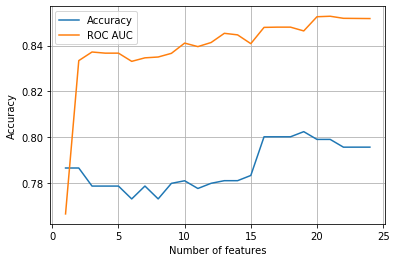

In [14]:
chart_x = list(range(1, number_of_features + 1))

plt.plot(chart_x, accuracy_by_feature_number,
        label = 'Accuracy')

plt.plot(chart_x, roc_auc_by_feature_number,
        label = 'ROC AUC')

plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

The results show that our ROC AUC* increases significantly between 1 and 2 features, and then climbs slowly up to about 20 features. Accuracy, interestingly, first declines with more features, and then climbs, to a plateau between 16 and 22 features.

Taking the top 20 features is likely to give us our best model (though we could reduce features more if computational time was critical).

*A reminder that ROC AUC is a measure of the balance between true positive and false positives as the threshold to classify a case as a positive is changed.